In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBSSBSBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.6 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1451.5| 42.0358|-111.9617|       SNWD|USC00109698|    43|[00 00 00 00 00 0...|2007.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     0|[F4 5D C0 5E C0 5...|1949.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     0|[90 5D 58 5E C0 5...|1950.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     1|[C0 54 60 52 C0 5...|1951.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     0|[58 5A 58 5A 58 5...|1952.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

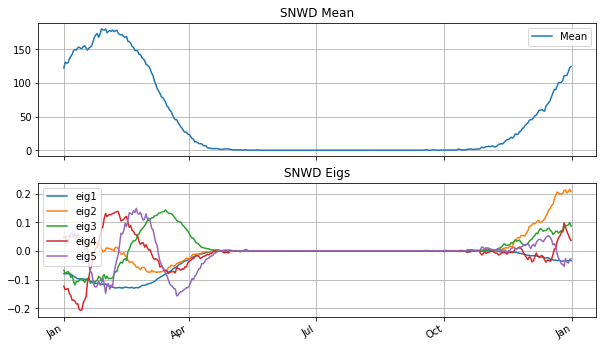

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=5
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

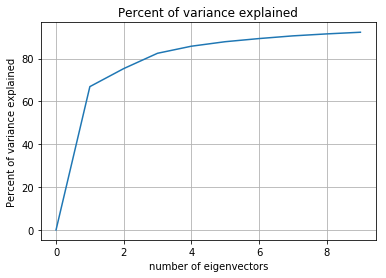

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1236
after filter 710


In [63]:
row

Row(coeff_1=1078.7601803588375, coeff_2=-167.56683613688932, coeff_3=377.8226521207637, coeff_4=48.408944545045145, coeff_5=187.0682281963485, elevation=1451.5, label=u'SBSSBSBB', latitude=42.0358, longitude=-111.9617, measurement=u'SNWD', res_1=0.4590638811408984, res_2=0.4569293326029867, res_3=0.2935537311626759, res_4=0.28543303742722265, res_5=0.22999994972801957, res_mean=1.6711368534059095, station=u'USC00109698', total_var=417315.0, undefs=43, vector=bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~\x00~\x00~\x00~\x00\x00\x00\x00\xc0T\xc0T\xc0T\x00~`V`R\x00\x00`R`V`V\x90Y\xf0[XZ\xc0X`V\xc0T`R@N\x00~\x00~\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0T\x00~\x00~\x00

In [12]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [57]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
        #Title='%s / %d    %s'%(row['station'],row['res_1'],row['coeff_1'])

    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                  %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [68]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_3)
rows=df4.take(12)
df4.select('coeff_3','res_1').show(4)

+-------------------+-------------------+
|            coeff_3|              res_1|
+-------------------+-------------------+
|-1862.8905755303028|0.34428354480247025|
|-1723.2467566552566|0.12820619997653698|
|-1518.4500486680327|0.21837820944184597|
|-1202.8371351127287| 0.4193768327387736|
+-------------------+-------------------+
only showing top 4 rows



0 0 0.53,r1=0.34,r2=0.34,r3=0.02 Axes(0.125,0.657941;0.168478x0.222059)
0 1 0.68,r1=0.13,r2=0.12,r3=0.04 Axes(0.327174,0.68;0.168478x0.2)
0 2 0.65,r1=0.22,r2=0.15,r3=0.07 Axes(0.529348,0.68;0.168478x0.2)
0 3 0.55,r1=0.42,r2=0.39,r3=0.24 Axes(0.731522,0.68;0.168478x0.2)
1 0 0.46,r1=0.34,r2=0.34,r3=0.10 Axes(0.125,0.44;0.168478x0.2)
1 1 0.48,r1=0.29,r2=0.22,r3=0.06 Axes(0.327174,0.44;0.168478x0.2)
1 2 0.50,r1=0.22,r2=0.22,r3=0.06 Axes(0.529348,0.44;0.168478x0.2)
1 3 0.50,r1=0.26,r2=0.25,r3=0.12 Axes(0.731522,0.44;0.168478x0.2)
2 0 0.59,r1=0.40,r2=0.40,r3=0.31 Axes(0.125,0.2;0.168478x0.2)
2 1 0.44,r1=0.39,r2=0.38,r3=0.15 Axes(0.327174,0.2;0.168478x0.2)
2 2 0.62,r1=0.32,r2=0.28,r3=0.22 Axes(0.529348,0.2;0.168478x0.2)
2 3 0.44,r1=0.14,r2=0.15,r3=0.10 Axes(0.731522,0.2;0.168478x0.2)


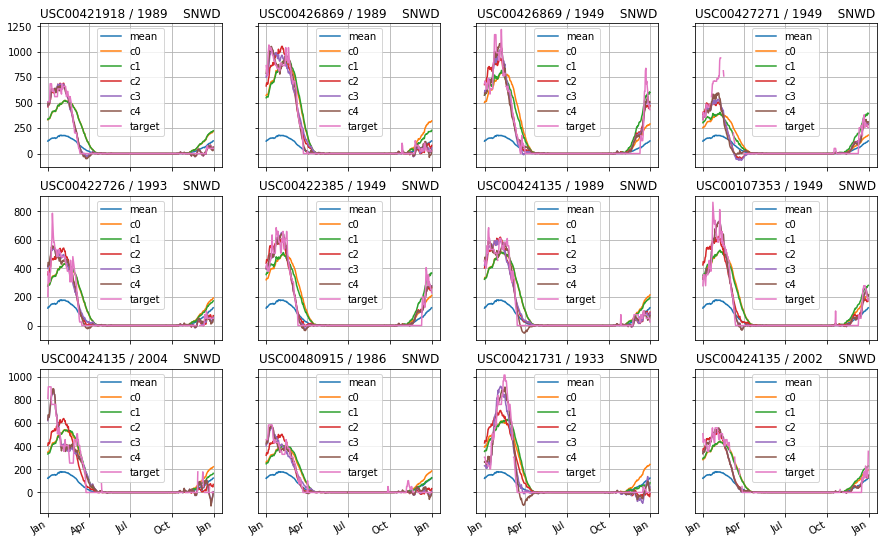

In [69]:
plot_recon_grid(rows)

In [70]:
df3.sort?

In [73]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_3,ascending=False)
rows=df5.take(12)
df5.select('coeff_3','res_1').show(4)

+------------------+-------------------+
|           coeff_3|              res_1|
+------------------+-------------------+
|2227.7208797390695|0.28334519701825905|
| 2120.281693577604|0.42086240117645873|
| 2085.765761031363| 0.1621790005490463|
| 2021.999015535438|0.25213000793484236|
+------------------+-------------------+
only showing top 4 rows



0 0 0.67,r1=0.28,r2=0.25,r3=0.05 Axes(0.125,0.657941;0.168478x0.222059)
0 1 0.63,r1=0.42,r2=0.32,r3=0.09 Axes(0.327174,0.68;0.168478x0.2)
0 2 0.69,r1=0.16,r2=0.16,r3=0.03 Axes(0.529348,0.68;0.168478x0.2)
0 3 0.66,r1=0.25,r2=0.23,r3=0.20 Axes(0.731522,0.68;0.168478x0.2)
1 0 0.70,r1=0.72,r2=0.20,r3=0.07 Axes(0.125,0.44;0.168478x0.2)
1 1 0.66,r1=0.29,r2=0.21,r3=0.07 Axes(0.327174,0.44;0.168478x0.2)
1 2 0.66,r1=0.42,r2=0.25,r3=0.14 Axes(0.529348,0.44;0.168478x0.2)
1 3 0.64,r1=0.22,r2=0.22,r3=0.14 Axes(0.731522,0.44;0.168478x0.2)
2 0 0.53,r1=0.34,r2=0.34,r3=0.11 Axes(0.125,0.2;0.168478x0.2)
2 1 0.53,r1=0.38,r2=0.35,r3=0.14 Axes(0.327174,0.2;0.168478x0.2)
2 2 0.58,r1=0.20,r2=0.20,r3=0.06 Axes(0.529348,0.2;0.168478x0.2)
2 3 0.68,r1=0.13,r2=0.13,r3=0.08 Axes(0.731522,0.2;0.168478x0.2)


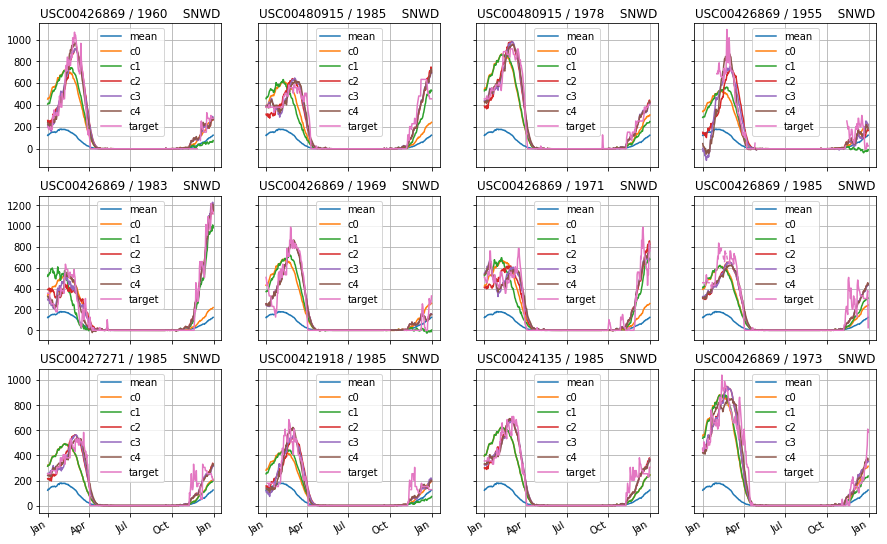

In [74]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.695033230282
residual normalized norm  after mean + top eigs: [ 0.71330126  0.38421064  0.28866323]


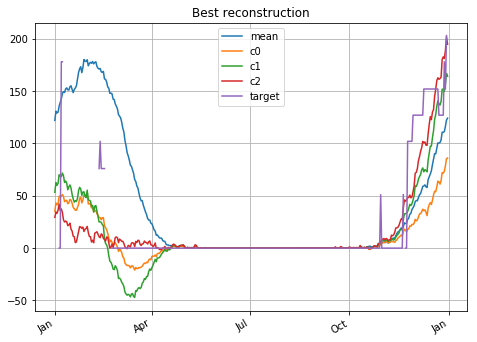

In [27]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [20]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

ValueError: x and y must have same first dimension, but have shapes (711,) and (710,)

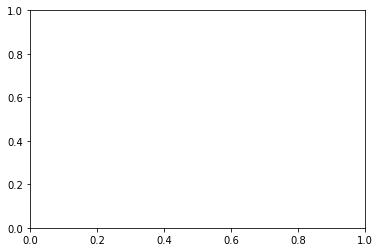

In [21]:
plot_CDF('res_2')

ValueError: x and y must have same first dimension, but have shapes (711,) and (710,)

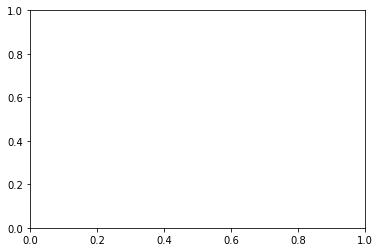

In [22]:
plot_CDF('coeff_2')

In [23]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [24]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.6M	../../Data/Weather/US_Weather_SBSSBSBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SBSSBSBB_PRCP.parquet
2.3M	../../Data/Weather/decon_SBSSBSBB_SNWD.parquet
